# DCA in backtest
Here to more simulate the trading, we use backtest module and implement a DCA strategy to verify it.
The goodness of `class Market` is we only need to care about how to react with it.  This allow user simulate more complicate trading operation like
sending order, cancel order,...etc

In [27]:
# Run it when crypto-backtest is updated, and then restart the kernel
!pip uninstall crypto-backtest -y
!pip install git+https://github.com/BullionBear/crypto-backtest.git

Found existing installation: crypto-backtest 0.0.12
Uninstalling crypto-backtest-0.0.12:
  Successfully uninstalled crypto-backtest-0.0.12
  Cloning https://github.com/BullionBear/crypto-backtest.git to /tmp/pip-req-build-z2fou63e
  Running command git clone --filter=blob:none --quiet https://github.com/BullionBear/crypto-backtest.git /tmp/pip-req-build-z2fou63e
  Resolved https://github.com/BullionBear/crypto-backtest.git to commit f0bffe1082e2927e455ed9df2d6352467e982e17
  Preparing metadata (setup.py) ... done
  Created wheel for crypto-backtest: filename=crypto_backtest-0.0.13-py3-none-any.whl size=10063 sha256=ce2166893176d27b46ac72ec9ce54e3531e66370b7b2e3480eef3b7d5db9360c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xxd0fml9/wheels/14/d1/5f/193347d44b51670dd287000ac535cdb7a8fc3f84e426532382
Successfully built crypto-backtest

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [105]:
import backtest
backtest.__version__

'develop_0.0.13+'

In [121]:
from backtest.components.core import ZipKLineIterator
from backtest.components import KLineMarket

from datetime import datetime, timezone

start_time = datetime(2023, 8, 1, tzinfo=timezone.utc).timestamp() * 1000
end_time = datetime(2023, 9, 1, tzinfo=timezone.utc).timestamp() * 1000
data_source = '/home/yite/crypto_data/binance/data'
kline_iterator = ZipKLineIterator('BTCUSDT', start_time, end_time, data_source)
market = KLineMarket(kline_iterator)

In [122]:
market.get_ts()

1690851599999

In [123]:
from backtest.models import MarketOrder

total_usdt = 1_000_000
invest_usdt = 30_000
klines = []
while True:
    if market.is_kline():
        kline = market.get_kline()
        dt = datetime.fromtimestamp(kline.close_time / 1000)
        price = kline.close
        amount = invest_usdt / price
        if dt.hour == 0:
            market_order = MarketOrder(
                timestamp=kline.close_time, 
                base='BTC', 
                quote='USDT', 
                side='BUY', 
                amount=amount
            )
            market.send_market(market_order)
        klines.append(kline)
    if not market.next():
        break
    

In [124]:
import pandas as pd
klines = pd.DataFrame(list(map(dict, klines)))
klines

,open,high,low,close,volume,open_time,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,29232.26,29288.20,29210.99,29283.96,720.85463,1690848000000,1690851599999,2.107947e+07,17954,341.10168,9.975408e+06,0
1,29283.96,29347.16,29169.37,29200.54,973.96678,1690851600000,1690855199999,2.850160e+07,26866,457.28798,1.338138e+07,0
2,29200.53,29218.74,28720.00,28933.22,5165.01282,1690855200000,1690858799999,1.495571e+08,88074,2152.09462,6.230125e+07,0
3,28933.22,28951.12,28813.86,28835.00,1813.18905,1690858800000,1690862399999,5.238132e+07,37227,797.90100,2.305322e+07,0
4,28835.01,28928.34,28803.50,28866.00,1752.08768,1690862400000,1690865999999,5.056954e+07,31403,832.45833,2.402522e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
738,26329.08,26387.32,26189.77,26292.23,1827.46445,1693504800000,1693508399999,4.804520e+07,36342,967.33071,2.543074e+07,0
739,26292.24,26319.40,25928.00,26162.79,4521.91272,1693508400000,1693511999999,1.182313e+08,72734,2046.23204,5.350037e+07,0
740,26162.79,26194.86,25959.72,26022.61,2429.77606,1693512000000,1693515599999,6.342360e+07,44244,1167.77055,3.048555e+07,0
741,26022.61,26037.97,25655.01,26024.57,4573.05529,1693515600000,1693519199999,1.183510e+08,80710,2220.69631,5.747478e+07,0


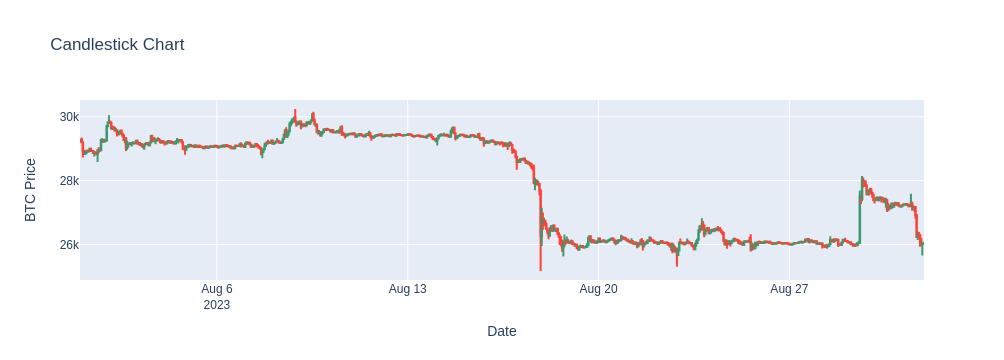

In [125]:
import pandas as pd
import plotly.graph_objects as go

klines['date'] = pd.to_datetime(klines['open_time'], unit='ms')

# Create a Candlestick chart
fig = go.Figure(data=[go.Candlestick(x=klines['date'],
                open=klines['open'],
                high=klines['high'],
                low=klines['low'],
                close=klines['close'])])

# Customize the layout
fig.update_layout(
    title='Candlestick Chart',
    yaxis_title='BTC Price',
    xaxis_title='Date',
    xaxis_rangeslider_visible=False  # Hides the range slider
)

# Show the figure
fig.show()

In [126]:
trades = []
while market.is_trade():
    trade = market.get_trade()
    trades.append(trade)

In [127]:
trades = pd.DataFrame(list(map(dict, trades)))
trades

,timestamp,execution_id,base,quote,side,filled,price,order_id
0,1690909200000,b8ae1077-d46e-40d8-aad0-12792489ca93,BTC,USDT,BUY,1.036771,28936.01,2ff5314d-989b-40c1-913d-08d3b629e21a
1,1690995600000,fea68a2c-cdc6-4871-bfe3-5deff835eedd,BTC,USDT,BUY,1.033559,29025.91,2205c8b2-c736-4aba-9806-a16b9c92d45f
2,1691082000000,2b39e11b-5dd2-462a-a1f8-f9fb7e814334,BTC,USDT,BUY,1.023802,29302.55,0fa146ef-ad1c-4215-8ef9-322184dd7753
3,1691168400000,76d963bc-3e77-4116-866d-c0b687759c5f,BTC,USDT,BUY,1.025102,29265.39,ae4c08d8-babb-4d0f-99da-8488ee78bf64
4,1691254800000,261f048b-3725-4ce6-a686-0cb31a507064,BTC,USDT,BUY,1.033317,29032.72,e83defc1-8c0d-4d4b-b493-181cf2d8beff
5,1691341200000,b4efa85d-4715-4d7b-a32c-97913c872488,BTC,USDT,BUY,1.031307,29089.30,e31ac3b1-6185-4606-8506-8e7ea2f2fa7d
6,1691427600000,72e0d6ab-bb27-4ffb-a711-b4fa84383bfc,BTC,USDT,BUY,1.036699,28937.99,8217d723-a675-4975-9657-dd86a3f23b73
7,1691514000000,68c3e0f1-66f5-4a10-bdfa-f6e507422032,BTC,USDT,BUY,1.008471,29748.00,ba87b170-8b27-469e-a6c4-735f02ca9a0b
8,1691600400000,c8452b4e-9058-40e8-95a6-54a6b9ce911a,BTC,USDT,BUY,1.016487,29513.41,9a149f59-5dc1-4369-8b2e-8a54db72205d
9,1691686800000,48d835d4-cc08-4c6a-8fbe-0e73f7d55ec2,BTC,USDT,BUY,1.019328,29431.16,6bcc43bc-98fc-40e1-91f4-eef00cab8000


In [128]:
# Reconstructing Portfolio NAV
btc_balance = 0
usdt_balance = total_usdt

assets = [{'timestamp': start_time, 'BTC': 0, 'USDT': total_usdt, 'nav': usdt_balance}]
# Applying trades from trading history
for trade in trades.to_dict("records"):
    btc_filled = trade['filled']
    btc_price = trade['price']
    usdt_amount = btc_filled * btc_price
    if trade['side'] == 'BUY':
        btc_balance += btc_filled
        usdt_balance -= usdt_amount
    else:
        btc_balance -= btc_filled
        usdt_balance += usdt_amount
    assets.append({'timestamp': trade['timestamp'], 'BTC': btc_balance, 'USDT': usdt_balance, 'nav': btc_balance * btc_price + usdt_balance})

df_asset = pd.DataFrame(assets)
df_asset.head()

,timestamp,BTC,USDT,nav
0,1.690848e+12,0.000000,1000000.000000,1.000000e+06
1,1.690909e+12,1.036771,969999.989632,1.000000e+06
2,1.690996e+12,2.070330,939999.989632,1.000093e+06
3,1.691082e+12,3.094132,909999.989632,1.000666e+06
4,1.691168e+12,4.119234,879999.979381,1.000551e+06


In [141]:
nav_records = []
idx = 0
for kline in klines.to_dict("records"):
    asset = assets[idx]
    while idx + 1 < len(assets) and asset['timestamp'] <= kline['open_time']:
        idx += 1
        asset = assets[idx]
    nav_records.append({'open': asset['BTC'] * kline['open'] + asset['USDT'],
                        'high': asset['BTC'] * kline['high'] + asset['USDT'],
                        'low': asset['BTC'] * kline['close'] + asset['USDT'],
                        'close': asset['BTC'] * kline['close'] + asset['USDT'],
                        'open_time': kline['open_time'], 'close_time': kline['close_time']})
nav_df = pd.DataFrame(nav_records)
nav_df

,open,high,low,close,open_time,close_time
0,1.000307e+06,1.000365e+06,1.000361e+06,1.000361e+06,1690848000000,1690851599999
1,1.000361e+06,1.000426e+06,1.000274e+06,1.000274e+06,1690851600000,1690855199999
2,1.000274e+06,1.000293e+06,9.999971e+05,9.999971e+05,1690855200000,1690858799999
3,9.999971e+05,1.000016e+06,9.998953e+05,9.998953e+05,1690858800000,1690862399999
4,9.998953e+05,9.999920e+05,9.999274e+05,9.999274e+05,1690862400000,1690865999999
...,...,...,...,...,...,...
738,9.502991e+05,9.522463e+05,9.490670e+05,9.490670e+05,1693504800000,1693508399999
739,9.490674e+05,9.499754e+05,9.447393e+05,9.447393e+05,1693508400000,1693511999999
740,9.447393e+05,9.458115e+05,9.400524e+05,9.400524e+05,1693512000000,1693515599999
741,9.400524e+05,9.405660e+05,9.401180e+05,9.401180e+05,1693515600000,1693519199999


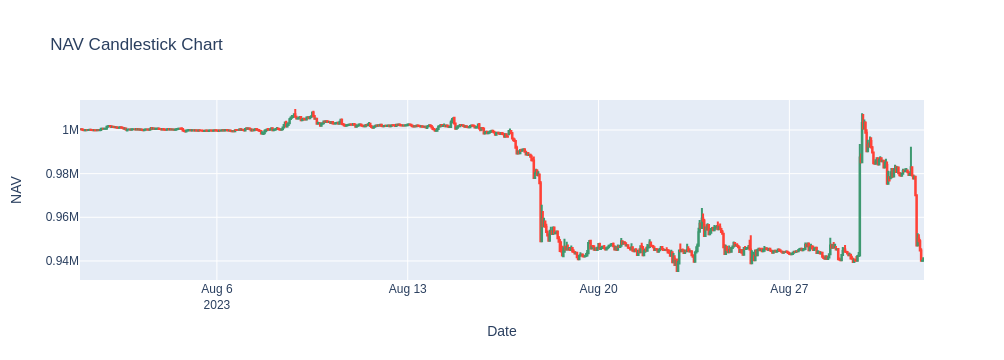

In [142]:
import pandas as pd
import plotly.graph_objects as go

nav_df['date'] = pd.to_datetime(nav_df['open_time'], unit='ms')

# Create a Candlestick chart
fig = go.Figure(data=[go.Candlestick(x=nav_df['date'],
                open=nav_df['open'],
                high=nav_df['high'],
                low=nav_df['low'],
                close=nav_df['close'])])

# Customize the layout
fig.update_layout(
    title='NAV Candlestick Chart',
    yaxis_title='NAV',
    xaxis_title='Date',
    xaxis_rangeslider_visible=False  # Hides the range slider
)

# Show the figure
fig.show()